In [170]:
BATCH_SIZE = 32
INPUT_SHAPE = (25, 16, 1)
DATASET_PATH = "output_frames"
DATASET_ZIP = "dataset.zip"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [171]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

In [172]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

No GPU detected.


In [173]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [174]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [175]:
# Function to load a ZIP file from Google Drive.
def load_zip_file(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract to a specific directory
            zip_ref.extractall(DATASET_PATH)
            print(f"ZIP file '{zip_path}' loaded successfully.")
    except FileNotFoundError:
        print(f"Error: ZIP file not found at '{zip_path}'.")
    except zipfile.BadZipFile:
        print(f"Error: Invalid ZIP file at '{zip_path}'.")

# If in Colab, load the ZIP file from Google Drive.
if IN_COLAB:
    print("Loading and extracting dataset ZIP-file form Drive.")
    if (not os.path.exists(DATASET_PATH)):
        load_zip_file("drive/MyDrive/Studies/KTH/Courses/II143X/Model Creation/Data/output_frames.zip")
        
# Otherwise, check of files exist.
else:
    print("No Colab detected, using pre-existing files.")
    if (not os.path.exists(DATASET_PATH)):
        print("Error: Dataset not found.")
        sys.exit()

No Colab detected, using pre-existing files.


In [176]:
#data2 = np.loadtxt("output_frames.csv", delimiter=",")


In [177]:
#data = np.genfromtxt("output_frames.csv", delimiter=",", encoding='utf-8')


In [178]:
df = pd.read_csv('output_frames.csv', header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [179]:
# (104707, 25, 16, 1)

In [180]:
dataset = dataset.reshape(dataset.shape[0], 25, 16, 1)

print(dataset.shape)
print(labels_set.shape)

(104707, 25, 16, 1)
(104707,)


In [181]:
print(labels_set[0:10])

['Background_noise' 'Background_noise' 'Background_noise'
 'Background_noise' 'Background_noise' 'Background_noise'
 'Background_noise' 'Background_noise' 'Background_noise'
 'Background_noise']


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [182]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


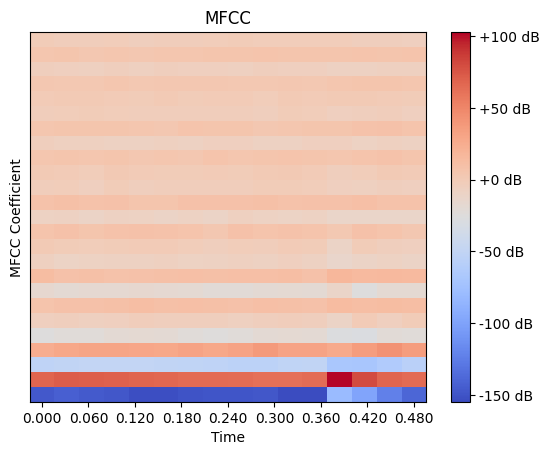

In [183]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [184]:
# Split the dataset into training and testing sets.
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 83765
Testing set length: 20942


In [185]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [186]:
print(dist_class_weight)

{0: 1.9336334256694367, 1: 0.9208992963940194, 2: 0.9252938317426652, 3: 0.9089675977168652, 4: 0.90000214887399, 5: 0.9050196637711223}


In [187]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))

In [188]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bicycle' 'Bus' 'Car' 'Motorcycle' 'Truck']


# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [189]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss']) 

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [190]:
# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, epochs, doPrintHistory, class_weight, verbose, batch_size):
    history = model.fit(x=x_train, y=y_train, validation_split=0.25, epochs=epochs, verbose=verbose, class_weight=class_weight, batch_size=batch_size)
    # Print history
    if doPrintHistory: printHistory(history)

# Construct Sequantial Model

...

In [191]:
# Creation of the sequential model
sequential_model = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = 'same', input_shape = INPUT_SHAPE),
    Conv2D(filters = 64, kernel_size = (2,2), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dropout(0.6),
    Dense(units = len(np.unique(labels_set)), activation = "softmax")
])


c:\Users\Pontu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [192]:
# Print a summary of the model architecture
sequential_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 25, 16, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 16, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 492,934 (1.88 MB)

 Trainable params: 492,934 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
# Compile the model.
sequential_model.compile(
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ['categorical_accuracy']
)

In [194]:
fitModel(sequential_model, x_train, y_train, 16, True, dist_class_weight, 1, 32)

Epoch 1/16
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - categorical_accuracy: 0.2045 - loss: 1.9006 - val_categorical_accuracy: 0.2740 - val_loss: 1.6982
Epoch 2/16
1741/1964 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - categorical_accuracy: 0.2683 - loss: 1.6806

KeyboardInterrupt: 